[//]: # (Here is a brief recap of this exercise.)

[//]: # (We first demonstrate our version of MLP with linear layers and Tanh non-linearities. Then your goal is to improve its performance.)

### Cells for you to implement (100 pts in total):
1. ReLU
    * 1.1 Forward (10 pts)
    * 1.2 Backward (10 pts)
2. MSE
    * 2.1 Forward (10 pts)
    * 2.2 Backward (10 pts)
3. Compute the number of parameters in MLP (10 pts)
4. Improve the architecture (10 pts)
5. Expose the learning rate (10 pts)
6. Apply MLP to RGB image
    * 6.1 Adapt to image as output (10 pts)
    * 6.2 Learning rate matters (10 pts)
7. High-frequencies as input (10 pts)

*Note*: no need to change any code until the `TASKS START HERE` cell. 

_____________

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Approximating a surface 

A neural network, or Multi Layer Perceptron (MLP) can be used as a universal function approximator. 
We will show it can be used to approximate a parametrized surface, with a point $x=(x_1, x_2)$ as input and $z = f(x)$ as output.

We will use an MLP to approximate the function from the lecture, (slide 26):

$$z = f(x) = 100(x_2-x_1^2)^2 + (1-x_1)^2$$

Let's first write a function $f$ that computes $z = f(x)$. Thanks to `numpy`, we can directly implement a vectorized version of $f$: if $x$ is an $(N \times 2)$ vector of input coordinates, $f(x)$ returns an array $z$ of shape $(N)$ where the i-th value in $z$ corresponds the i-th row of $x$.

In [3]:
def f(x):
    '''
    inputs:
        x: (np.array) - (N x 2) vector of input coordinates
    
    outputs:
        z: (np.array) - (N) shape z = f(x) computed at input points x
    '''
    return 100 * (x[:,1] - x[:,0]**2)**2 + (1 - x[:,0])**2

We now visualize our function with get_coord_grid:

In [4]:
def get_coord_grid(min_val=0, max_val=1, num_x=100, num_y=100):
    '''
    inputs:
        min_val, max_val (float): minimum and maximum values in the grid range
        num_x, num_y (int): number of points to sample
    outputs:
        coord_grid (np.array): (num_x*num_y x 2) - the grid of input 2D coordinates, reshaped in the array of points
    '''
    assert min_val < max_val
    
    coord_grid = np.meshgrid(
        np.linspace(min_val, max_val, num_x),
        np.linspace(min_val, max_val, num_y),
        indexing='xy',
    )
    coord_grid = np.stack(coord_grid, axis=-1) # num_x x num_y x 2 
    coord_grid = coord_grid.reshape(-1, 2)
    return coord_grid

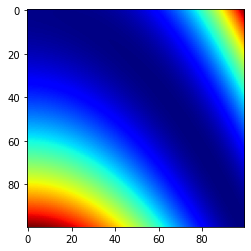

In [5]:
num_px = 100
coord_grid = get_coord_grid(0, 1, num_px, num_px)
values = f(coord_grid)

plt.imshow(values.reshape(num_px, num_px), cmap='jet')

Let's implement the MLP network as proposed in the lecture:

<img src="mlp.png"  width="300">

## MLP

We provide our implementation of an MLP, and ask you to improve it.

Since our goal is to train our MLP with gradient-based optimization, for each mathematical operation we implement, we must also define its gradients in the `backward` function.

Let's start with the basic building block of MLPs: linear layers.


In [6]:
class LinearLayer:
    def __init__(self, num_input_dims: int, num_output_dims: int):
        # Initialization: weights and biases are initialized randomly
        self.weight = np.random.randn(num_input_dims, num_output_dims) * np.sqrt(2 / num_input_dims)
        self.bias = np.random.randn(num_output_dims)
    
    def forward(self, input):
        # Forward pass of the linear layer: matrix multiplication + bias
        intermediate_activations = [input] # we will need input for the backward pass
        output = np.dot(input, self.weight) + self.bias
        
        return output, intermediate_activations
    
    def backward(self, grad_wrt_output, intermediate_activations):
        # Backward pass of the Linear layer
        assert len(intermediate_activations) == 1
        input = intermediate_activations[0]

        grad_wrt_input = np.dot(grad_wrt_output, self.weight.T)
        # We use the input to the linear layer to compute the gradients
        grad_wrt_weight = np.dot(input.T, grad_wrt_output)
        grad_wrt_bias = np.sum(grad_wrt_output, axis=0)

        grad_wrt_params = [grad_wrt_weight, grad_wrt_bias]

        return grad_wrt_input, grad_wrt_params

    def get_parameters(self):
        # Linear layer has 2 parameter groups to optimize: weight and bias
        return [self.weight, self.bias]
    
    def replace_parameters(self, updates):
        # Given a list of new parameters (updates), replace the parameters of the layer
        assert len(updates) == 2

        weight, bias = updates
        if weight.shape != self.weight.shape:
            raise ValueError(f"wrong weight shape: {weight.shape} != {self.weight.shape}")
        if bias.shape != self.bias.shape:
            raise ValueError(f"wrong bias shape: {bias.shape} != {self.bias.shape}")
        
        self.weight = weight
        self.bias = bias

We then define an MLP as a succession of LinearLayers:

In [7]:
class MultiLayerPerceptron:
    def __init__(self, widths, activation_layer):
        """
        widths:             list of integers representing layer widths
        activation_layer:   instance of a class implementing forward and 
                            backward pass of the activation function
                            between linear layers
        """
        self.layers = []

        for i in range(len(widths) - 1):
            self.layers.append(LinearLayer(widths[i], widths[i+1])) # linear layer
            self.layers.append(activation_layer) # non-linear transformation
        
        self.layers.pop() # remove last activation layer (no activation on the output)

    def forward(self, input):
        """
        Iterates over the layers of the network (alternating between linear layers and activation functions)
        and computes the output of the network and intermediate activations for each layer.
        """
        intermediate_activations = []
        output = input

        for layer in self.layers:
            output, intermediate_activations_for_layer = layer.forward(output)
            intermediate_activations.append(intermediate_activations_for_layer)

        return output, intermediate_activations
    
    def backward(self, grad_wrt_output, intermediate_activations):
        # Computes the gradients of the loss with respect to the parameters of the network
        grad_wrt_params = [] # gradients wrt params in the order of layers

        for layer, intermediate_activations_for_layer in zip(self.layers[::-1], intermediate_activations[::-1]):
            grad_wrt_output, grad_wrt_params_for_layer = layer.backward(grad_wrt_output, intermediate_activations_for_layer)
            grad_wrt_params = grad_wrt_params_for_layer + grad_wrt_params

        return grad_wrt_params
    
    def get_parameters(self):
        # Returns the parameters of all the network's layers
        params = []

        for layer in self.layers:
            params += layer.get_parameters()

        return params

    def replace_parameters(self, updates):
        # Given a list of new parameters (updates), replace the parameters of each layer
        assert len(updates) == len(self.get_parameters())

        index = 0
        for layer in self.layers:
            n_parameters = len(layer.get_parameters())
            layer.replace_parameters(updates[index:n_parameters + index])
            index += n_parameters


The above code describes the chaining of linear layers and activation functions to form an MLP. Between each linear layer, we apply an activation function. A standard choice for it, the hyperbolic tanget ($tanh$), is defined as 

\begin{align}
tanh(z) = \frac{2}{1+e^{-2z}} - 1
\end{align}

and its derivative reads:

\begin{align}
tanh'(z) = 1 - tanh(z)^2
\end{align}

We implement this function and its derivative below.

In [8]:
class TanhLayer:
    def forward(self, input):
        intermediate_activations = [input]
        output = 2. / (1. + np.exp(-2*input)) - 1
        
        return output, intermediate_activations

    def backward(self, grad_wrt_output, intermediate_activations):
        assert len(intermediate_activations) == 1 # detect bugs early
        input = intermediate_activations[0]

        # Re-use the input to compute the gradient
        output = 2. / (1. + np.exp(-2*input)) - 1
        grad = 1 - output**2
        
        # Apply the chain rule: multiply by incoming gradient
        grad_wrt_input = grad_wrt_output * grad
        
        grad_wrt_params = [] # we have no parameters
        return grad_wrt_input, grad_wrt_params
    
    def get_parameters(self):
        return [] # no parameters
    
    def replace_parameters(self, updates):
        pass # no parameters, nothing to do

The last ingredient to train a neural network is a loss function to be minimized during training. We start by using the L1 loss function. 

Here we assume that $\mathbf{y}$ is the ground-truth value of the surface: $\mathbf{y} = f(\mathbf{x})$, and define $\mathcal L_1$ as

\begin{align}
\mathcal L_1 = \frac {1}{N} \sum _{i=1}^{N} |\hat{\mathbf{y}}_{i}-{\mathbf{y}_{i}}|
\end{align}

In [9]:
def l1_error_forward(y_true, y_pred):
    error = np.mean(np.abs(y_true - y_pred))
    return error

We can compute its (sub-)derivative w.r.t. the predictions $\hat{\mathbf{y}}_{i}$ as

\begin{align}
\frac{\partial \mathcal L _1 }{\partial \hat{\mathbf{y}}_{i}} = \begin{cases}
               \frac {-1}{N}        & \mathbf{y}_{i} \geq \hat{\mathbf{y}}_{i} \\
               \frac {1}{N}       & \mathbf{y}_{i} < \hat{\mathbf{y}}_{i} \\ \end{cases}
\end{align}

Note that since the L1 error is not differentiable, we use a sub-derivative, i.e. generalized derivatives for convex functions which are not necessarily differentiable.

In [10]:
def l1_error_backward(y_true, y_pred):
    gradient = np.sign(y_pred - y_true) / y_true.size
    return gradient

Finally, we can write our training loop doing gradient descent:

In [11]:
def fit_fixed_lr(coord_grid, values, network, loss_forward, loss_backward, num_iterations=5000):
    cartesian_errors = []
    for _ in range(num_iterations):
        # Forward pass through the network: compute predictions
        predictions, activations = network.forward(coord_grid)

        # Compute and store the loss
        error = loss_forward(values, predictions)
        cartesian_errors.append(error)

        # Compute the gradient of the loss with respect to predictions
        gradient = loss_backward(values, predictions)
        # And then propagate it backwards through the network
        grads = network.backward(gradient, activations)
        
        # Update the network parameters with 1 step of gradient descent
        current = network.get_parameters()
        updates = [p - 0.001 * g for p, g in zip(current, grads)]
        network.replace_parameters(updates)
    
    return cartesian_errors

We can now train our first network (this step should take between 10 and 60 seconds):

In [12]:
def visualize_results(errors_arr, predictions, targets):
    fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(5*3,5))
    a0.semilogy(errors_arr)
    a1.imshow(targets, cmap='jet')
    a1.set_title("Ground-truth shape")
    a2.imshow(predictions, cmap='jet')
    a2.set_title(f"Approximated shape ( Loss: {errors_arr[-1]:.3f} )")
    for a in [a1,a2]: a.set_axis_off()

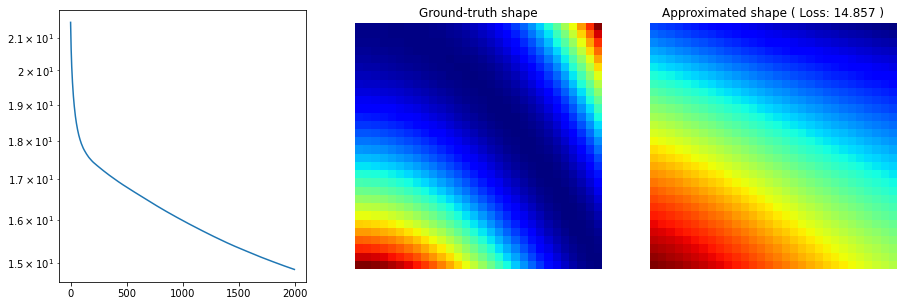

In [13]:
num_px = 30
coord_grid = get_coord_grid(0, 1, num_px, num_px)
values = f(coord_grid).reshape(-1,1)

mlp_tanh = MultiLayerPerceptron([2, 512, 1], TanhLayer()) ### Start with a simple shallow network
errors = fit_fixed_lr(coord_grid, values, mlp_tanh, l1_error_forward, l1_error_backward, num_iterations=2000)

visualize_results(
    errors,
    mlp_tanh.forward(coord_grid)[0].reshape(num_px, num_px),
    values.reshape(num_px, num_px)
)

This first implementation is not working very well, and your task is to fill out the following cells to improve it.

______

# TASKS START HERE

______


## 1. Different activation function: ReLU (20 pts)

One of the most popular activation functions nowadays, the Rectified Linear Unit (ReLU), is defined as 

\begin{align}
ReLU(z) = \begin{cases}
               0               & z<0\\
               z               & z\geq 0\\ \end{cases}
\end{align}

and its (sub-)derivative reads:

\begin{align}
\frac{d ReLU}{dz}(z) = \begin{cases}
               0               & z<0\\
               1               & z\geq 0\\ \end{cases}
\end{align}

**Implement this function (10 pts) and its derivative (10 pts) below.**

__Hint__: Recall that the __forward__ method computes the layer's primary function, while the __backward__ method is here to allow backpropagation of gradients through the network.

In [14]:
class ReLULayer:
    def forward(self, input):
        intermediate_activations = [input]
        
        ###
        ## TO IMPLEMENT
        # output = ...
        output = input * (input > 0)
        ###
        
        return output, intermediate_activations

    def backward(self, grad_wrt_output, intermediate_activations):
        assert len(intermediate_activations) == 1 # detect bugs early
        input = intermediate_activations[0]

        ###
        ## TO IMPLEMENT
        # drelu_dinput = ...
        drelu_dinput = (input > 0).astype(float)
        ###

        # Apply the chain rule: multiply by incoming gradient
        grad_wrt_input = grad_wrt_output * drelu_dinput
        
        grad_wrt_params = [] # we have no parameters
        return grad_wrt_input, grad_wrt_params
    
    def get_parameters(self):
        return [] # no parameters
    
    def replace_parameters(self, updates):
        pass # no parameters, nothing to do

Define and test an `mlp_relu` that uses the same architecture parameters as `mlp_tanh`, but with ReLU activation functions. It should work only slightly better, but train faster.

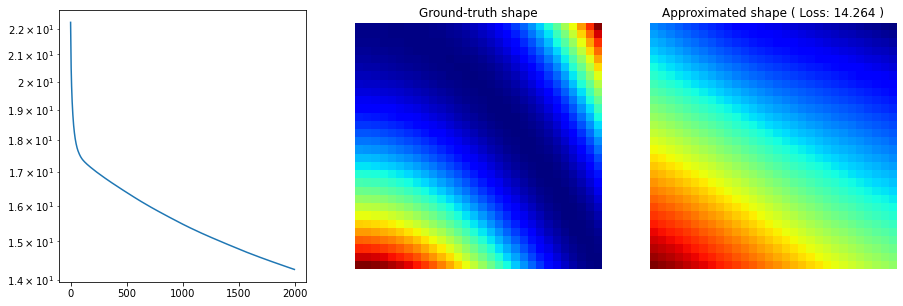

In [15]:
mlp_relu = MultiLayerPerceptron([2, 512, 1], ReLULayer())
errors = fit_fixed_lr(coord_grid, values, mlp_relu, l1_error_forward, l1_error_backward, num_iterations=2000)

visualize_results(
    errors,
    mlp_relu.forward(coord_grid)[0].reshape(num_px, num_px),
    values.reshape(num_px, num_px)
)

_____

## 2. Different loss function: MSE (20 pts)

Let us use another loss function to train our network: the Mean Square Error. By using a square term, it penalizes high errors more.

Again, we assume that $\mathbf{y}$ is the ground-truth value of the surface: $\mathbf{y} = f(\mathbf{x})$, and the loss $\mathcal L _{\text{MSE}}$ of our predictions $\hat{\mathbf{y}}_{i}$ is

\begin{align}
\mathcal L _{\text{MSE}} =\frac {1}{N} \sum _{i=1}^{N} \left(\hat{\mathbf{y}}_{i}-{\mathbf{y}_{i}}\right)^{2}.
\end{align}

**Define its computation below (10 pts)**:

In [16]:
def mean_squared_error_forward(y_true, y_pred):
    ###
    ## TO IMPLEMENT
    # error = ...
    error = np.mean(np.power(y_true - y_pred, 2))
    ###
    return error

We also need to compute its derivative w.r.t. the predictions $\hat{\mathbf{y}}_{i}$ as

\begin{align}
\frac{\partial \mathcal L _{\text{MSE}} }{\partial \hat{\mathbf{y}}_{i}} =\frac {2}{N} \left(\hat{\mathbf{y}}_{i}-{\mathbf{y}_{i}}\right).
\end{align}

**Fill out the cell below (10 pts)**:

In [17]:
def mean_squared_error_backward(y_true, y_pred):
    ###
    ## TO IMPLEMENT
    # gradient = ...
    gradient = 2 * (y_pred - y_true) / y_true.size
    ###
    return gradient

Again, define a ReLU MLP but train it with MSE instead of L1 this time:

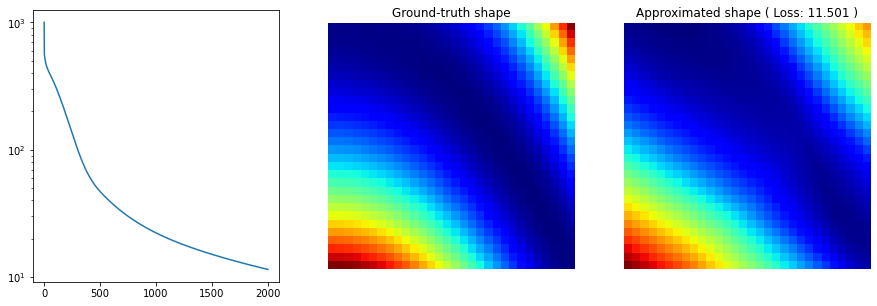

In [18]:
mlp_relu = MultiLayerPerceptron([2, 512, 1], ReLULayer())
errors = fit_fixed_lr(coord_grid, values, mlp_relu, mean_squared_error_forward, mean_squared_error_backward, num_iterations=2000)

visualize_results(
    errors,
    mlp_relu.forward(coord_grid)[0].reshape(num_px, num_px),
    values.reshape(num_px, num_px)
)

You should visually notice a much better fit of the target surface.

_____

## 3. Compute the number of parameters (10 pts)

Implement the function below **(10 pts)** so that it returns the number of parameters of the MLP network. The number of parameters equals to the accumulated amounts of elements in the weights and bias matrices in all layers. With the same network architecture, both the ReLU MLP and the Tanh MLP should give you the same result.

__Hint__: use the method `get_parameters()` of `MultiLayerPerceptron`, which returns the weights and bias matrices.

In [19]:
def compute_num_params(network):
    ###
    ## TO IMPLEMENT
    # num = ...
    num = sum([p.size for p in network.get_parameters()])
    ###
    return num

In [20]:
compute_num_params(mlp_relu)

2049

_______

## 4. Design the network architecture (10 pts)

Can we modify the architecture so that the network has fewer parameters but achieves a better performance at the same time? Let's make it happen.

Create a network `mlp_relu_2` below that has fewer parameters than `mlp_relu`, but has more linear layers. Validate your design using the `compute_num_params()` you've just implemented. The correct design is not unique.

__Hint:__ read the `__init__()` function of `MultiLayerPerception` and understand the meaning of its arguments. What data type `width` should be? What are the meanings of its length and the values in it?

In [21]:
###
## TO IMPLEMENT
# mlp_relu_2 = ...
mlp_relu_2 = MultiLayerPerceptron([2, 32,32,16, 1], ReLULayer())
###

print(compute_num_params(mlp_relu_2))

1697


Then train your network and test its performance:

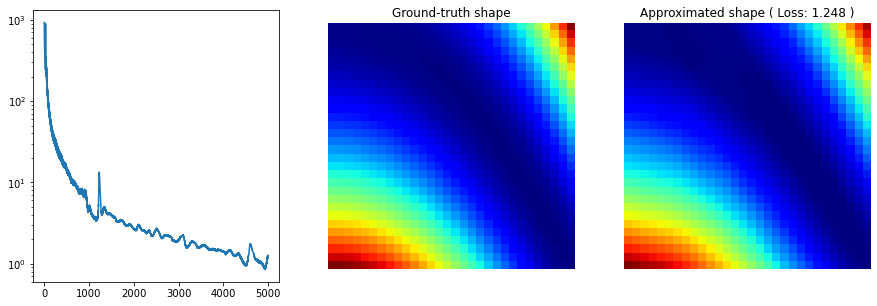

In [22]:
errors = fit_fixed_lr(coord_grid, values, mlp_relu_2, mean_squared_error_forward, mean_squared_error_backward)

visualize_results(
    errors,
    mlp_relu_2.forward(coord_grid)[0].reshape(num_px, num_px),
    values.reshape(num_px, num_px)
)

You should notice that your lighter but deeper network achieves better performances (lower MSE).

_______

## 5. Expose the learning rate parameter (10 pts)
The above function `fit_fixed_lr` uses a fixed learning rate  (i.e. 0.001) for the gradient descent. Take inspiration from it and **fill out the code of the `fit` function below (10 pts)** which has an additional parameter `learning_rate` to control it:

In [23]:
def fit(coord_grid, values, network, loss_forward, loss_backward, learning_rate=0.001, num_iterations=5000):
    cartesian_errors = []

    ###
    ## TO IMPLEMENT:
    for _ in range(num_iterations):
        # Forward pass through the network: compute predictions
        predictions, activations = network.forward(coord_grid)
        
        # Compute and store the loss
        error = loss_forward(values, predictions)
        cartesian_errors.append(error)

        # Compute the gradient of the loss with respect to predictions
        gradient = loss_backward(values, predictions)
        # And then propagate it backwards through the network
        grads = network.backward(gradient, activations)

        # Update the network parameters with 1 step of gradient descent
        current = network.get_parameters()
        updates = [p - learning_rate * g for p, g in zip(current, grads)]
        network.replace_parameters(updates)
    ###
    
    return cartesian_errors

Fit your customized network again, but with a learning rate of 0.0001:

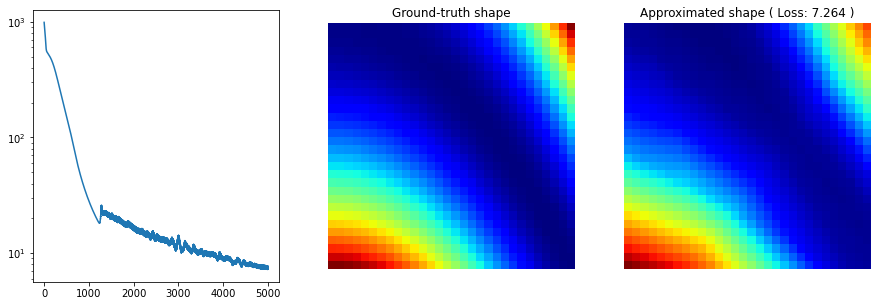

In [24]:
###
## TO IMPLEMENT
# mlp_relu_2 = ...
# errors = fit(...)
mlp_relu_2 = MultiLayerPerceptron([2, 32,32,16, 1], ReLULayer())
errors = fit(coord_grid, values, mlp_relu_2, mean_squared_error_forward, mean_squared_error_backward, learning_rate=0.0001)
###

visualize_results(
    errors,
    mlp_relu_2.forward(coord_grid)[0].reshape(num_px, num_px),
    values.reshape(num_px, num_px)
)

_______

## 6. Apply MLP to RGB image (20 pts)

As a versatile function approximator, the MLP can handle various data. In this section, you will try to work with the image data. In particular, we will make a network memorize a small image crop. Let's load and visualize the image first.

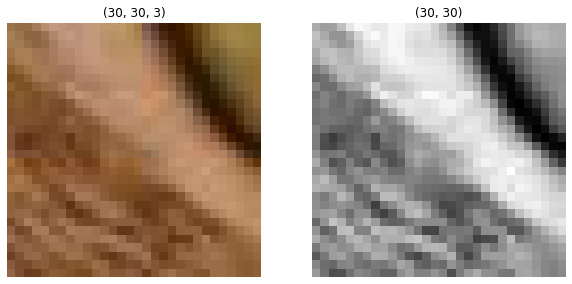

In [25]:
image_rgb = plt.imread("image.jpg") / 255
image_gray = image_rgb.mean(axis=-1)

fig, ax = plt.subplots(1,2,figsize=(10,5))
for axis, img in zip(ax, [image_rgb, image_gray]):
    axis.imshow(img, cmap='gray')
    axis.set_title(img.shape)
    axis.set_axis_off()

## 6.1 Implement the image MLP (10 pts)

This time, instead of regressing a single scalar per input 2D coordinate
$$z = f(x,y)\,\,,$$ 

let's regress a triplet, namely the RGB intensities:
$$r,g,b = f(x,y)\,\,.$$

What should be done to implement this new functionality? Implement the code below **(10 pts)**.

__Hint:__ you can keep the same configurations of your customized and improved MLP, namely using the same number of layers and the same widths of hidden layers.

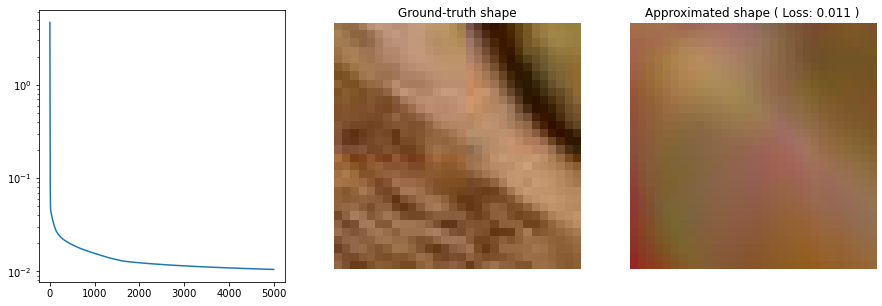

In [26]:
image = image_rgb.copy()
num_channels = 3

values_rgb = image.reshape(-1, num_channels)
coord_grid_rgb = get_coord_grid(0, 1, image.shape[1], image.shape[0])

###
## TO IMPLEMENT:
# mlp_image = ...
mlp_image = MultiLayerPerceptron([2, 64, 128, 64, num_channels], ReLULayer())
###

errors = fit(coord_grid_rgb, values_rgb, mlp_image, mean_squared_error_forward, mean_squared_error_backward)

visualize_results(
    errors,
    mlp_image.forward(coord_grid_rgb)[0].reshape(image.shape),
    image
)

_____

## 6.2 The learning rate matters (10 pts)

Initialize the MLP again as you did above. Run the same experiment but with `learning rate = 1`. Explain why the MLP does not work this time, __write your answer below__.

/Users/guillard/miniconda3/envs/py37torch2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/Users/guillard/miniconda3/envs/py37torch2/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


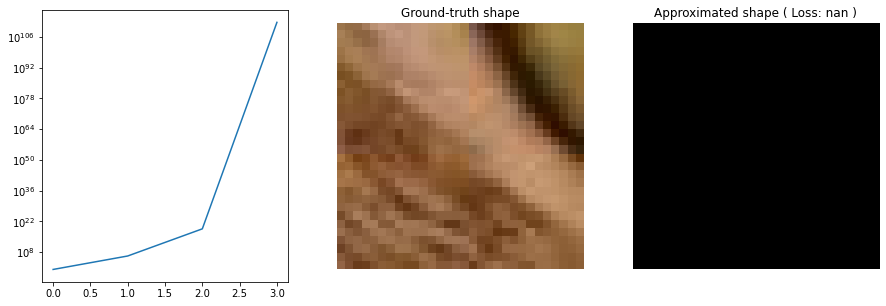

In [27]:
lr = 1.

###
## TO IMPLEMENT:
# mlp_image = ...
# errors = ...
mlp_image = MultiLayerPerceptron([2, 64, 128, 64, num_channels], ReLULayer())
errors = fit(
    coord_grid_rgb, values_rgb, mlp_image, mean_squared_error_forward, mean_squared_error_backward, 
    learning_rate=lr)
###

visualize_results(
    errors,
    mlp_image.forward(coord_grid_rgb)[0].reshape(image.shape),
    image
)

__YOUR ANSWER FOR THE QUESTION:__ **(5 pts)**

Too large step size for the gradient descent to happen: the loss is not minimized and numpy overflows.

_____

### Try different learning rates

The choice of learning rates can be critical to your MLP's performance. A good practice is to try different options and use the best one.

Implement a loop below (**5 pts**) that trains MLPs with different plausible learning rates (at least 3) and shows how they perform:

0.0001
0.001
0.01


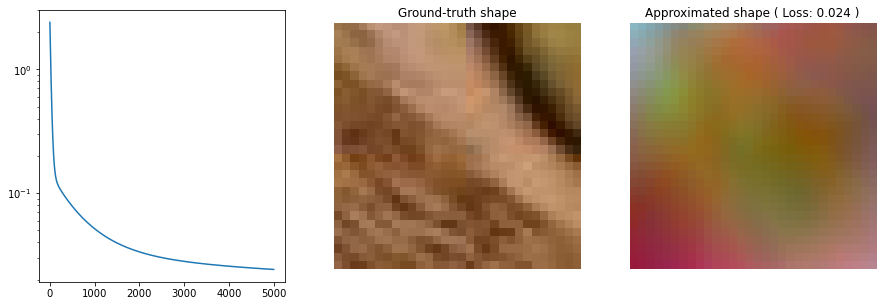

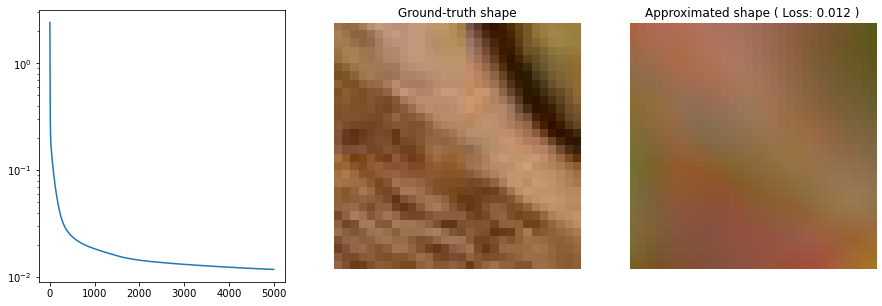

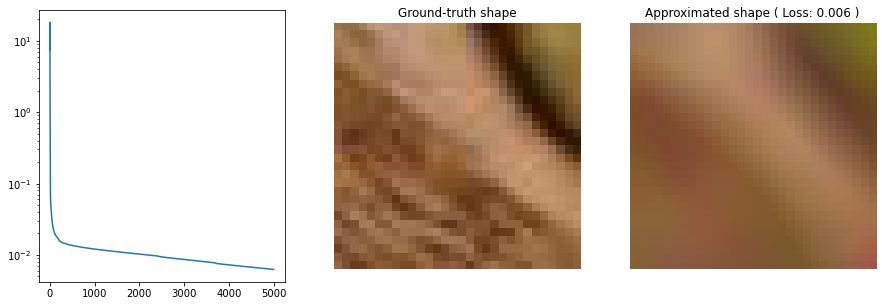

In [28]:
### TO IMPLEMENT
# for lr in ...
for lr in [0.0001, 0.001, 0.01]:
    print(lr)
    mlp = MultiLayerPerceptron([2, 64, 128, 64, num_channels], ReLULayer()) 
    
    errors = fit(
        coord_grid_rgb, values_rgb, mlp, mean_squared_error_forward, mean_squared_error_backward, 
        learning_rate=lr)

    visualize_results(
        errors,
        mlp.forward(coord_grid_rgb)[0].reshape(image.shape),
        image
    )
###

_____________

## 7. Introduce high-freq input (10 pts)

### Sample coordinates from the fourier grid instead of cartesian

The above network cannot accurately fit the image. One common trick is to encode the input $(x,y)$ coordinates with Fourier features:
$$
(x,y) \rightarrow \left(\sin(2\pi f_1 x),\, \sin(2\pi f_1 y),\, \cos(2\pi f_1 x),\, \cos(2\pi f_1 y),\, \sin(2\pi f_2 x),\, \sin(2\pi f_2 y), ...,\, \cos(2\pi f_N x),\, \cos(2\pi f_N y) \right)
$$
with $f_1, ..., f_N$ fixed frequencies. This feature expansion allows the MLP to handle more complicated data at higher frequencies.

Below we provide one implementation for $N=5$.

In [29]:
def fourier_features(coords):
    xs, ys = coords.T
    freqs = np.array([[1, 2, 4, 8, 16]]) / 16
    
    return np.concatenate([
        np.sin(2 * np.pi * freqs * xs[:, None]),
        np.sin(2 * np.pi * freqs * ys[:, None]),
        np.cos(2 * np.pi * freqs * xs[:, None]),
        np.cos(2 * np.pi * freqs * ys[:, None]),
    ], axis=-1)

ff_grid = fourier_features(coord_grid_rgb)
print(ff_grid.shape)


(900, 20)


Now you need to consider how to modify the experiment to work with the high-freq coordinates.

Modify the MLP architecture again so that it can run on fourier features as inputs instead of cartesian coordinates **(10 pts)**:

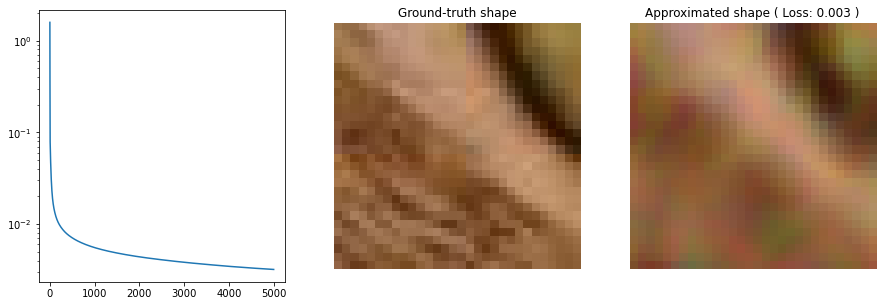

In [30]:
### TO IMPLEMENT:
# mlp_fourier = ...
mlp_fourier = MultiLayerPerceptron([ff_grid.shape[-1], 64, 128, 64, num_channels], ReLULayer()) # change input channels
###

fourier_errors = fit(
    ff_grid, values_rgb, mlp_fourier, mean_squared_error_forward, mean_squared_error_backward, 
    learning_rate=0.01)

visualize_results(
    fourier_errors,
    mlp_fourier.forward(ff_grid)[0].reshape(image.shape),
    image
)

At the same time, fit an MLP on cartesian coordinates for comparison (repeat the training you performed earlier, no points awarded this time):

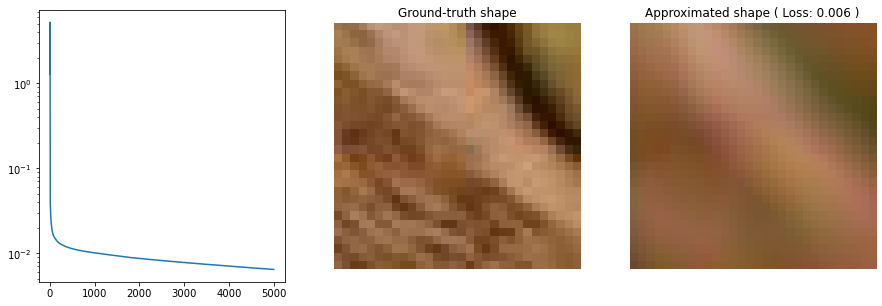

In [31]:
###
## TO IMPLEMENT
mlp_cartesian = MultiLayerPerceptron([2, 64, 128, 64, num_channels], ReLULayer()) 

cartesian_errors = fit(
    coord_grid_rgb, values_rgb, mlp_cartesian, mean_squared_error_forward, mean_squared_error_backward, 
    learning_rate=0.01)

visualize_results(
    cartesian_errors,
    mlp_cartesian.forward(coord_grid_rgb)[0].reshape(image.shape),
    image
)
###

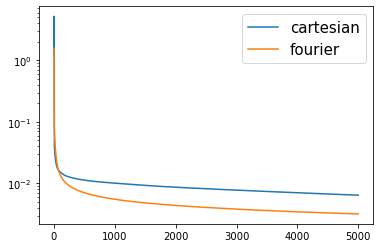

In [32]:
plt.semilogy(cartesian_errors, label='cartesian')
plt.semilogy(fourier_errors, label='fourier')
plt.legend(fontsize=15)

You should notice a better convergence of the network using Fourier features as input.